# **Key Phrase Analysis**

This notebook performs an analysis to identify key phrases used by account executives in sales transcripts and evaluates their impact on sales outcomes using embeddings and clustering techniques. We'll follow a systematic workflow that includes data loading, text preprocessing, embedding generation, clustering, key phrase extraction, statistical analysis, and interpretation.

## **Table of Contents**
1. [Introduction](#introduction)
2. [Data Loading and Preparation](#data-loading-and-preparation)
3. [Text Preprocessing](#text-preprocessing)
4. [Embedding Generation](#embedding-generation)
5. [Clustering Embeddings](#clustering-embeddings)
6. [Key Phrase Extraction](#key-phrase-extraction)
7. [Data Aggregation](#data-aggregation)
   - 7.1 [Meeting-Level Aggregation](#meeting-level-aggregation)
   - 7.2 [Phrase-Level Aggregation with Frequency](#phrase-level-aggregation)
8. [Statistical Analysis](#statistical-analysis)
   - 8.1 [Meeting-Level Analysis](#meeting-level-analysis)
   - 8.2 [Phrase-Level Analysis](#phrase-level-analysis)
9. [Model Interpretation](#model-interpretation)
10. [Visualization](#visualization)
11. [Conclusion](#conclusion)

---

In [1]:
# # Install necessary packages
# import subprocess
# import sys

# # Install tqdm
# subprocess.check_call([sys.executable, "-m", "pip", "install", "tqdm"])

# from tqdm.notebook import tqdm

# packages = [
#     "pandas", "matplotlib", "seaborn", "scipy",
#     "scikit-learn", "sentence_transformers", "nltk", "umap-learn",
#     "imblearn", "gspread", "spacy", "numpy<2.0", "threadpoolctl", "statsmodels"
# ]

# # Install packages individually with tqdm progress bar
# for package in tqdm(packages, desc="Installing packages"):
#     subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# # Download spaCy model
# result = subprocess.run("python -m spacy download en_core_web_sm", shell=True, capture_output=True, text=True)

In [2]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy.stats import chi2_contingency
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import spacy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time
import warnings
import ast  # 🔧✨ Modification: Import ast to handle string to list conversion

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

# Display settings
%matplotlib inline
pd.set_option('display.max_columns', None)

# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
_ = nltk.download('wordnet', quiet=True)

# For reproducibility
np.random.seed(42)

c:\Users\akosiyawin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


<a id='introduction'></a>
## **1. Introduction**

The goal of this analysis is to identify key phrases used by account executives in sales transcripts and determine their impact on sales outcomes. By leveraging embeddings and clustering techniques, we aim to uncover phrases that correlate with successful sales (`closed_won`) or longer sales cycles.

**Data Structure:**

- **IDs List (`ids`):** A list of dictionaries containing transcript IDs and their corresponding sales outcomes.
- **Meeting Data (`meeting_df`):** Contains meeting-level information for each transcript (does not include `sales_outcome`).
- **Sentences Data (`sentences_df`):** Contains sentence-level data, including speaker information and the text spoken.

**Steps Involved:**

1. Load and prepare the data from multiple transcripts.
2. Preprocess the text data.
3. Generate embeddings for sentences spoken by account executives.
4. Cluster the embeddings to identify key phrases.
5. Extract representative key phrases for each cluster.
6. Aggregate data at both meeting and phrase levels.
7. Perform statistical analysis to identify significant phrases.
8. Interpret the model coefficients and provide insights.
9. Visualize the results.
10. Draw conclusions and suggest actionable insights.

<a id='data-loading-and-preparation'></a>
## **2. Data Loading and Preparation**

We'll start by loading the dataset from multiple transcripts and preparing it for analysis.

**Note:** We have added an exponential backoff retry mechanism to handle any transient errors during data loading.

In [3]:
from services.gspread import (
    gspread_try_get_cells_by_range,
    gspread_try_get_service_account_from_file,
    gspread_try_get_spreadsheet_by_id,
    gspread_try_get_worksheet_by_id
)

# Check if 'all_sentences_df.csv' exists
if os.path.exists('all_sentences_df.csv'):
    # Read the DataFrame from the CSV file
    all_sentences_df = pd.read_csv('all_sentences_df.csv')
    print("Loaded 'all_sentences_df.csv' successfully.")
else:
    # Get data from Google Sheets
    service_account = gspread_try_get_service_account_from_file('secret_sales_meetings_report_service_account.json')
    spreadsheet = gspread_try_get_spreadsheet_by_id(
        service_account,
        '19AYpEl2TeqUAAZ-pqGU3c9j6rtzzFbWgRrEjHA_ozYM'  # Production spreadsheet
    )
    sheet_metrics_per_transcript = gspread_try_get_worksheet_by_id(spreadsheet, 1963712501)

    # Fetch IDs from Google Sheets
    ids = gspread_try_get_cells_by_range(sheet_metrics_per_transcript, 'A3:E')

    # Convert list of dictionaries
    ids = [
        {
            'id': row[0],
            'sales_outcome': row[4],
        }
        for row in ids
    ]

    from algorithms.get_transcript import get_transcript_dfs

    # Convert the list of dictionaries to a DataFrame and remove duplicates
    ids_df = pd.DataFrame(ids)
    ids_df = ids_df.drop_duplicates(subset='id')
    ids = ids_df.to_dict('records')

    # Initialize an empty list to store all sentences
    all_sentences = []

    # Iterate over the IDs with tqdm for progress tracking
    for item in tqdm(ids, desc="Processing IDs"):
        transcript_id = item['id']
        sales_outcome = item['sales_outcome']

        retries = 5
        delay = 2  # Initial delay in seconds
        for attempt in range(1, retries + 1):
            try:
                # Fetch the dataframes
                transcript_dfs = get_transcript_dfs(transcript_id)
                meeting_df = transcript_dfs['meeting_df']
                sentences_df = transcript_dfs['sentences_df']

                # Add 'sales_outcome' to sentences_df
                sentences_df['sales_outcome'] = sales_outcome
                sentences_df['id'] = transcript_id

                # Filter for account executives
                ae_sentences = sentences_df[sentences_df['is_account_executive']]

                # Append to list
                all_sentences.append(ae_sentences)

                # Break out of the retry loop if successful
                break
            except Exception as e:
                if attempt == retries:
                    print(f"Failed to process transcript_id {transcript_id} after {retries} attempts.")
                    raise e  # Re-raise the exception after final attempt
                else:
                    wait_time = delay * (2 ** (attempt - 1))  # Exponential backoff
                    print(f"Attempt {attempt} failed for transcript_id {transcript_id}. Retrying in {wait_time} seconds...")
                    time.sleep(wait_time)

    # Concatenate all sentences into a single DataFrame
    all_sentences_df = pd.concat(all_sentences, ignore_index=True)

    # Display the first few rows
    print(all_sentences_df.head())

    # Export the DataFrame to CSV
    all_sentences_df.to_csv('all_sentences_df.csv', index=False)
    print("Saved 'all_sentences_df.csv' successfully.")


Loaded 'all_sentences_df.csv' successfully.


<a id='text-preprocessing'></a>
## **3. Text Preprocessing**

We'll clean and prepare the text data for embedding generation, focusing on extracting meaningful content by retaining only nouns and adjectives. We'll set up the text preprocessing procedure to break down each sentence into individual phrases.

In [4]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
custom_stop_words = stop_words.union({'yeah', 'um', 'so', 'like', 'uh', 'hmm'})
lemmatizer = WordNetLemmatizer()

def preprocess_text_spacy_adj_nouns(text):
    # Check for NaN
    if pd.isnull(text):
        return []
    
    # Process the text with spaCy
    doc = nlp(text.lower())
    
    # Initialize list to hold meaningful phrases
    phrases = []
    
    # Extract noun chunks (noun phrases)
    for chunk in doc.noun_chunks:
        # Collect adjectives and nouns within the chunk
        tokens = [
            token.text
            for token in chunk
            if token.pos_ in ['ADJ', 'NOUN', 'PROPN'] and token.is_alpha and not token.is_stop and token.text not in custom_stop_words
        ]
        if tokens:
            phrase = ' '.join(tokens)
            phrases.append(phrase)
    
    # Extract named entities
    entities = [
        ent.text.lower()
        for ent in doc.ents
        if ent.label_ in ['PERSON', 'ORG', 'GPE', 'PRODUCT', 'EVENT']
    ]
    phrases.extend(entities)
    
    # Remove duplicates while preserving order
    seen = set()
    unique_phrases = []
    for phrase in phrases:
        if phrase not in seen:
            seen.add(phrase)
            unique_phrases.append(phrase)
    
    return unique_phrases

# Enable the tqdm progress bar for pandas apply
tqdm.pandas()

# 🔧✨ Modification: Use 'ast.literal_eval' to convert 'phrases' column back to lists
# Check if 'all_sentences_df_with_phrases.csv' exists
if os.path.exists('all_sentences_df_with_phrases.csv'):
    # Load the DataFrame with phrases
    all_sentences_df = pd.read_csv('all_sentences_df_with_phrases.csv')
    print("Loaded 'all_sentences_df_with_phrases.csv' successfully.")
    
    # Convert 'phrases' column from string representation to actual lists
    all_sentences_df['phrases'] = all_sentences_df['phrases'].progress_apply(ast.literal_eval)
else:
    # Check if 'all_sentences_df.csv' exists
    if os.path.exists('all_sentences_df.csv'):
        # Load the DataFrame without phrases
        all_sentences_df = pd.read_csv('all_sentences_df.csv')
        print("Loaded 'all_sentences_df.csv' successfully.")
    else:
        # Get data from Google Sheets
        service_account = gspread_try_get_service_account_from_file('secret_sales_meetings_report_service_account.json')
        spreadsheet = gspread_try_get_spreadsheet_by_id(
            service_account,
            '19AYpEl2TeqUAAZ-pqGU3c9j6rtzzFbWgRrEjHA_ozYM'  # Production spreadsheet
        )
        sheet_metrics_per_transcript = gspread_try_get_worksheet_by_id(spreadsheet, 1963712501)
    
        # Fetch IDs from Google Sheets
        ids = gspread_try_get_cells_by_range(sheet_metrics_per_transcript, 'A3:E')
    
        # Convert list of dictionaries
        ids = [
            {
                'id': row[0],
                'sales_outcome': row[4],
            }
            for row in ids
        ]
    
        # Convert the list of dictionaries to a DataFrame and remove duplicates
        ids_df = pd.DataFrame(ids)
        ids_df = ids_df.drop_duplicates(subset='id')
        ids = ids_df.to_dict('records')
    
        # Initialize an empty list to store all sentences
        all_sentences = []
    
        # Iterate over the IDs with tqdm for progress tracking
        for item in tqdm(ids, desc="Processing IDs"):
            transcript_id = item['id']
            sales_outcome = item['sales_outcome']
    
            retries = 5
            delay = 2  # Initial delay in seconds
            for attempt in range(1, retries + 1):
                try:
                    # Fetch the dataframes
                    transcript_dfs = get_transcript_dfs(transcript_id)
                    meeting_df = transcript_dfs['meeting_df']
                    sentences_df = transcript_dfs['sentences_df']
    
                    # Add 'sales_outcome' to sentences_df
                    sentences_df['sales_outcome'] = sales_outcome
                    sentences_df['id'] = transcript_id
    
                    # Filter for account executives
                    ae_sentences = sentences_df[sentences_df['is_account_executive']]
    
                    # Append to list
                    all_sentences.append(ae_sentences)
    
                    # Break out of the retry loop if successful
                    break
                except Exception as e:
                    if attempt == retries:
                        print(f"Failed to process transcript_id {transcript_id} after {retries} attempts.")
                        raise e  # Re-raise the exception after final attempt
                    else:
                        wait_time = delay * (2 ** (attempt - 1))  # Exponential backoff
                        print(f"Attempt {attempt} failed for transcript_id {transcript_id}. Retrying in {wait_time} seconds...")
                        time.sleep(wait_time)
    
        # Concatenate all sentences into a single DataFrame
        all_sentences_df = pd.concat(all_sentences, ignore_index=True)
    
        # Display the first few rows
        print(all_sentences_df.head())
    
        # Export the DataFrame to CSV
        all_sentences_df.to_csv('all_sentences_df.csv', index=False)
        print("Saved 'all_sentences_df.csv' successfully.")

        # Assign the DataFrame to proceed with phrases extraction
        all_sentences_df = all_sentences_df

    # Apply the updated preprocessing function
    all_sentences_df['phrases'] = all_sentences_df['text'].progress_apply(preprocess_text_spacy_adj_nouns)
    
    # Display the phrases
    print(all_sentences_df[['text', 'phrases']].head())
    
    # Export the DataFrame to CSV with phrases
    all_sentences_df.to_csv('all_sentences_df_with_phrases.csv', index=False)
    print("Saved 'all_sentences_df_with_phrases.csv' successfully.")


Loaded 'all_sentences_df.csv' successfully.


  0%|          | 0/685601 [00:00<?, ?it/s]

                                                text                 phrases
0              Time out of your day to meet with me.             [time, day]
1  I know that my assistant Ian emailed you a vid...  [assistant ian, video]
2                                              Yeah.                      []
3                                        Albert Ian.            [albert ian]
4                                     Okay, awesome.                      []
Saved 'all_sentences_df_with_phrases.csv' successfully.


In [5]:
all_sentences_df.head()

,speaker_name,speaker_id,text,start_time,end_time,task,pricing,metric,question,date_and_time,sentiment,speaker_email,is_account_executive,sales_outcome,id,phrases
0,Shawn Henderson,0,Time out of your day to meet with me.,0.330,2.302,NaN,NaN,NaN,NaN,NaN,NaN,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,"[time, day]"
1,Shawn Henderson,0,I know that my assistant Ian emailed you a vid...,2.356,6.800,NaN,NaN,NaN,I know that my assistant Ian emailed you a vid...,NaN,NaN,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,"[assistant ian, video]"
2,Shawn Henderson,0,Yeah.,8.634,9.182,NaN,NaN,NaN,NaN,NaN,NaN,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,[]
3,Shawn Henderson,0,Albert Ian.,9.316,10.458,NaN,NaN,NaN,NaN,NaN,NaN,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,[albert ian]
4,Shawn Henderson,0,"Okay, awesome.",10.634,12.960,NaN,NaN,NaN,NaN,NaN,NaN,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,[]


### **Explode Phrases Into Separate Rows**

We will expand the DataFrame so that each phrase has its own row.

In [6]:
# 🔧✨ Modification: Ensure 'phrases' column contains lists before exploding
# Check if 'expanded_df.parquet' exists
if os.path.exists('expanded_df.parquet'):
    # Load the DataFrame from the Parquet file
    expanded_df = pd.read_parquet('expanded_df.parquet')
    print("Loaded 'expanded_df.parquet' successfully.")
else:
    # Ensure 'phrases' column contains lists, not strings
    if all_sentences_df['phrases'].apply(lambda x: isinstance(x, list)).all():
        print("Confirmed that 'phrases' column contains lists.")
    else:
        print("Converting 'phrases' column to lists using ast.literal_eval.")
        all_sentences_df['phrases'] = all_sentences_df['phrases'].apply(ast.literal_eval)
    
    # Explode the phrases into separate rows
    expanded_df = all_sentences_df.explode('phrases').reset_index(drop=True)
    
    # Rename 'phrases' to 'clean_text' for consistency
    expanded_df.rename(columns={'phrases': 'clean_text'}, inplace=True)
    
    # Drop rows where 'clean_text' is NaN or empty
    expanded_df = expanded_df[expanded_df['clean_text'].notna() & (expanded_df['clean_text'] != '')]
    
    # Display the expanded DataFrame
    print(expanded_df.head())
    
    # Save the DataFrame to a Parquet file
    expanded_df.to_parquet('expanded_df.parquet', index=False)
    print("Saved 'expanded_df.parquet' successfully.")


Confirmed that 'phrases' column contains lists.
      speaker_name  speaker_id  \
0  Shawn Henderson           0   
1  Shawn Henderson           0   
2  Shawn Henderson           0   
3  Shawn Henderson           0   
5  Shawn Henderson           0   

                                                text  start_time  end_time  \
0              Time out of your day to meet with me.       0.330     2.302   
1              Time out of your day to meet with me.       0.330     2.302   
2  I know that my assistant Ian emailed you a vid...       2.356     6.800   
3  I know that my assistant Ian emailed you a vid...       2.356     6.800   
5                                        Albert Ian.       9.316    10.458   

  task pricing metric                                           question  \
0  NaN     NaN    NaN                                                NaN   
1  NaN     NaN    NaN                                                NaN   
2  NaN     NaN    NaN  I know that my assistant Ia

In [7]:
expanded_df.head()

,speaker_name,speaker_id,text,start_time,end_time,task,pricing,metric,question,date_and_time,sentiment,speaker_email,is_account_executive,sales_outcome,id,clean_text
0,Shawn Henderson,0,Time out of your day to meet with me.,0.330,2.302,NaN,NaN,NaN,NaN,NaN,NaN,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,time
1,Shawn Henderson,0,Time out of your day to meet with me.,0.330,2.302,NaN,NaN,NaN,NaN,NaN,NaN,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,day
2,Shawn Henderson,0,I know that my assistant Ian emailed you a vid...,2.356,6.800,NaN,NaN,NaN,I know that my assistant Ian emailed you a vid...,NaN,NaN,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,assistant ian
3,Shawn Henderson,0,I know that my assistant Ian emailed you a vid...,2.356,6.800,NaN,NaN,NaN,I know that my assistant Ian emailed you a vid...,NaN,NaN,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,video
5,Shawn Henderson,0,Albert Ian.,9.316,10.458,NaN,NaN,NaN,NaN,NaN,NaN,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,albert ian


<a id='embedding-generation'></a>
## **4. Embedding Generation**

We'll generate embeddings for each phrase using a pre-trained model.

In [8]:
# Check if 'expanded_df_with_embeddings.parquet' exists
if os.path.exists('expanded_df_with_embeddings.parquet'):
    # Load the DataFrame with embeddings from Parquet
    expanded_df = pd.read_parquet('expanded_df_with_embeddings.parquet')
    print("Loaded 'expanded_df_with_embeddings.parquet' successfully.")
else:
    # Load the model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Generate embeddings using the individual phrases
    embeddings = model.encode(expanded_df['clean_text'].tolist(), show_progress_bar=True)
    
    # Add embeddings to DataFrame
    expanded_df['embedding'] = embeddings.tolist()
    
    # Display the first few embeddings
    expanded_df.head()
    
    # Save the expanded DataFrame to a Parquet file
    expanded_df.to_parquet('expanded_df_with_embeddings.parquet', index=False)
    print("Saved 'expanded_df_with_embeddings.parquet' successfully.")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/30221 [00:00<?, ?it/s]

Saved 'expanded_df_with_embeddings.parquet' successfully.


<a id='clustering-embeddings'></a>
## **5. Clustering Embeddings**

We'll cluster the phrase embeddings to identify groups of similar phrases.

In [9]:
from sklearn.cluster import MiniBatchKMeans

# Set environment variables to limit thread usage
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

# Check if 'expanded_df_with_clusters.parquet' exists
if os.path.exists('expanded_df_with_clusters.parquet'):
    # Load the DataFrame from the Parquet file
    expanded_df = pd.read_parquet('expanded_df_with_clusters.parquet')
    print("Loaded 'expanded_df_with_clusters.parquet' successfully.")
else:
    # Ensure 'expanded_df_with_embeddings.parquet' is available
    if not os.path.exists('expanded_df_with_embeddings.parquet'):
        raise FileNotFoundError("expanded_df_with_embeddings.parquet not found. Please generate it first.")
    
    # Load the embeddings DataFrame
    expanded_df = pd.read_parquet('expanded_df_with_embeddings.parquet')
    print("Loaded 'expanded_df_with_embeddings.parquet' successfully.")
    
    # Convert embeddings to float32 to save memory
    try:
        embedding_array = np.array(expanded_df['embedding'].tolist(), dtype=np.float32)
    except MemoryError:
        print("MemoryError: Unable to convert embeddings to a NumPy array with float32.")
        print("Consider reducing the dataset size or using incremental processing.")
        raise
    
    # Dimensionality Reduction using PCA (Incremental)
    print("Starting PCA dimensionality reduction...")
    pca = PCA(n_components=0.95, random_state=42)
    
    # Fit PCA on the entire dataset (if memory allows)
    try:
        reduced_embeddings = pca.fit_transform(embedding_array)
    except MemoryError:
        print("MemoryError: PCA transformation failed due to insufficient memory.")
        print("Consider using IncrementalPCA or reducing the dataset size.")
        raise
    
    print("PCA completed successfully.")
    
    # Clustering using MiniBatchKMeans
    print("Starting MiniBatchKMeans clustering...")
    num_clusters = 100  # Adjust as needed
    
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=10000)
    try:
        kmeans.fit(reduced_embeddings)
    except MemoryError:
        print("MemoryError: MiniBatchKMeans clustering failed due to insufficient memory.")
        print("Consider reducing the number of clusters or the batch size.")
        raise
    
    print("Clustering completed successfully.")
    
    # Step 7: Assign cluster labels
    expanded_df['cluster'] = kmeans.labels_
    
    # Step 8: Display cluster assignments
    print("Cluster assignments:")
    print(expanded_df[['id', 'cluster']].head())
    
    # Step 9: Export the DataFrame with cluster assignments to Parquet
    expanded_df.to_parquet('expanded_df_with_clusters.parquet', index=False)
    print("Saved 'expanded_df_with_clusters.parquet' successfully.")


Loaded 'expanded_df_with_embeddings.parquet' successfully.
Starting PCA dimensionality reduction...
PCA completed successfully.
Starting MiniBatchKMeans clustering...
Clustering completed successfully.
Cluster assignments:
                 id  cluster
0  FxuRiyttDW782zH3       28
1  FxuRiyttDW782zH3       59
2  FxuRiyttDW782zH3       39
3  FxuRiyttDW782zH3       74
4  FxuRiyttDW782zH3       42
Saved 'expanded_df_with_clusters.parquet' successfully.


<a id='key-phrase-extraction'></a>
## **6. Key Phrase Extraction**

We'll extract representative key phrases for each cluster.

In [10]:
# Check if 'expanded_df_with_key_phrases.parquet' exists
if os.path.exists('expanded_df_with_key_phrases.parquet'):
    # Load the DataFrame from the Parquet file
    expanded_df = pd.read_parquet('expanded_df_with_key_phrases.parquet')
    print("Loaded 'expanded_df_with_key_phrases.parquet' successfully.")
else:
    # Ensure 'expanded_df' is available
    # If not, load it from the previous Parquet file
    if 'expanded_df' not in locals():
        if os.path.exists('expanded_df_with_clusters.parquet'):
            expanded_df = pd.read_parquet('expanded_df_with_clusters.parquet')
            print("Loaded 'expanded_df_with_clusters.parquet' successfully.")
        else:
            raise FileNotFoundError("expanded_df_with_clusters.parquet not found. Please generate it first.")

    # Ensure 'num_clusters' is defined
    if 'num_clusters' not in locals():
        num_clusters = expanded_df['cluster'].nunique()

    # Initialize a dictionary to store cluster labels
    cluster_labels = {}

    for cluster_num in range(num_clusters):
        # Filter phrases in the cluster
        cluster_phrases = expanded_df[expanded_df['cluster'] == cluster_num]

        if cluster_phrases.empty:
            # Assign 'N/A' if the cluster has no phrases
            key_phrase = 'N/A'
            print(f"Cluster {cluster_num} has no phrases. Assigned key phrase: {key_phrase}\n")
        else:
            # Get all phrases in the cluster
            phrases = cluster_phrases['clean_text'].tolist()

            # Count the frequency of each phrase
            phrase_counts = pd.Series(phrases).value_counts()

            # Assign the most frequent phrase as the key phrase
            key_phrase = phrase_counts.index[0]
            print(f"Cluster {cluster_num} assigned key phrase: {key_phrase}\n")

        # Store the assigned key phrase
        cluster_labels[cluster_num] = key_phrase

    # Map cluster labels
    expanded_df['key_phrase'] = expanded_df['cluster'].map(cluster_labels)

    # Display the DataFrame with key phrases
    print(expanded_df[['clean_text', 'cluster', 'key_phrase']].head())

    # Export the DataFrame with key phrases to Parquet
    expanded_df.to_parquet('expanded_df_with_key_phrases.parquet', index=False)
    print("Saved 'expanded_df_with_key_phrases.parquet' successfully.")


Cluster 0 assigned key phrase: copy

Cluster 1 assigned key phrase: images

Cluster 2 assigned key phrase: goal

Cluster 3 assigned key phrase: experience

Cluster 4 assigned key phrase: amazon

Cluster 5 assigned key phrase: listings

Cluster 6 assigned key phrase: advertising

Cluster 7 assigned key phrase: team

Cluster 8 assigned key phrase: brand

Cluster 9 assigned key phrase: business

Cluster 10 assigned key phrase: things

Cluster 11 assigned key phrase: value

Cluster 12 assigned key phrase: idea

Cluster 13 assigned key phrase: keywords

Cluster 14 assigned key phrase: week

Cluster 15 assigned key phrase: acos

Cluster 16 assigned key phrase: month

Cluster 17 assigned key phrase: seo

Cluster 18 assigned key phrase: lot

Cluster 19 assigned key phrase: premium

Cluster 20 assigned key phrase: people

Cluster 21 assigned key phrase: type

Cluster 22 assigned key phrase: sellers

Cluster 23 assigned key phrase: category

Cluster 24 assigned key phrase: email

Cluster 25 assi

<a id='data-aggregation'></a>
## **7. Data Aggregation**

We'll perform two types of data aggregation:

### **7.1 Meeting-Level Aggregation**

Here, we aggregate key phrases at the meeting level, indicating whether each key phrase was used in the meeting.

In [11]:
# Check if 'meeting_level_df.parquet' exists
if os.path.exists('meeting_level_df.parquet'):
    # Load the DataFrame from the Parquet file
    meeting_level_df = pd.read_parquet('meeting_level_df.parquet')
    print("Loaded 'meeting_level_df.parquet' successfully.")
else:
    # Ensure 'expanded_df' is available
    if 'expanded_df' not in locals():
        # Try to load 'expanded_df_with_key_phrases.parquet'
        if os.path.exists('expanded_df_with_key_phrases.parquet'):
            expanded_df = pd.read_parquet('expanded_df_with_key_phrases.parquet')
            print("Loaded 'expanded_df_with_key_phrases.parquet' successfully.")
        else:
            raise FileNotFoundError("expanded_df_with_key_phrases.parquet not found. Please generate it first.")

    # Group by meeting ID and collect unique key phrases
    meeting_key_phrases = expanded_df.groupby('id')['key_phrase'].apply(lambda x: list(set(x))).reset_index()

    # Get the sales outcome for each meeting
    meeting_outcomes = expanded_df[['id', 'sales_outcome']].drop_duplicates()

    # Merge key phrases with sales outcomes
    meeting_level_df = pd.merge(meeting_key_phrases, meeting_outcomes, on='id')

    # Create binary features for each key phrase
    mlb = MultiLabelBinarizer()
    key_phrase_matrix = mlb.fit_transform(meeting_level_df['key_phrase'])
    key_phrase_df = pd.DataFrame(key_phrase_matrix, columns=mlb.classes_)
    meeting_level_df = pd.concat([meeting_level_df, key_phrase_df], axis=1)

    # Map sales outcome to binary
    meeting_level_df['sales_outcome_binary'] = meeting_level_df['sales_outcome'].map({'closed_won': 1, 'closed_lost': 0})

    # Display the meeting-level DataFrame
    print(meeting_level_df.head())

    # Export the DataFrame to Parquet
    meeting_level_df.to_parquet('meeting_level_df.parquet', index=False)
    print("Saved 'meeting_level_df.parquet' successfully.")


                 id                                         key_phrase  \
0  02sSTbnKU8tcA6ER  [k, people, case, images, things, supplements,...   
1  043070R2pGkyS1di  [k, people, pricing, case, images, things, sup...   
2  04rguU1dLQSCaIJV  [images, supplements, inventory, ones, goal, o...   
3  05nWIZEiCL16w81I  [images, supplements, inventory, ones, goal, o...   
4  07NqbOgiZ5nv58CO  [k, people, pricing, case, images, things, sup...   

  sales_outcome  access  account  acos  advertising  agency  amazon  asins  \
0   closed_lost       1        1     0            0       1       1      0   
1   closed_lost       1        0     0            1       0       1      0   
2    closed_won       1        1     1            1       1       1      1   
3   closed_lost       0        0     0            1       1       1      1   
4   closed_lost       0        1     1            1       0       1      1   

   audit  brand  budget  business  care  case  catalog  category  characters  \
0     

**Implications:**

- **Pros:** Captures whether a key phrase was mentioned in a meeting, linking it to the overall sales outcome.
- **Cons:** Does not consider how frequently a phrase was mentioned, potentially overlooking the impact of repetition.

### **7.2 Phrase-Level Aggregation with Frequency**

In this approach, we consider the frequency of each key phrase within each meeting.

In [12]:
# Check if 'phrase_level_df.parquet' exists
if os.path.exists('phrase_level_df.parquet'):
    # Load the DataFrame from the Parquet file
    phrase_level_df = pd.read_parquet('phrase_level_df.parquet')
    print("Loaded 'phrase_level_df.parquet' successfully.")
else:
    # Ensure 'expanded_df' is available
    if 'expanded_df' not in locals():
        # Try to load 'expanded_df_with_key_phrases.parquet'
        if os.path.exists('expanded_df_with_key_phrases.parquet'):
            expanded_df = pd.read_parquet('expanded_df_with_key_phrases.parquet')
            print("Loaded 'expanded_df_with_key_phrases.parquet' successfully.")
        else:
            raise FileNotFoundError("expanded_df_with_key_phrases.parquet not found. Please generate it first.")

    # Phrase-Level Aggregation with Frequency

    # Count the frequency of each key phrase per meeting
    phrase_frequency = expanded_df.groupby(['id', 'key_phrase']).size().unstack(fill_value=0).reset_index()

    # Get the sales outcome for each meeting
    meeting_outcomes = expanded_df[['id', 'sales_outcome']].drop_duplicates()

    # Merge phrase frequencies with sales outcomes
    phrase_level_df = pd.merge(phrase_frequency, meeting_outcomes, on='id')

    # Map sales outcome to binary
    phrase_level_df['sales_outcome_binary'] = phrase_level_df['sales_outcome'].map({'closed_won': 1, 'closed_lost': 0})

    # Display the phrase-level DataFrame
    print(phrase_level_df.head())

    # Export the DataFrame to Parquet
    phrase_level_df.to_parquet('phrase_level_df.parquet', index=False)
    print("Saved 'phrase_level_df.parquet' successfully.")


                 id  access  account  acos  advertising  agency  amazon  \
0  02sSTbnKU8tcA6ER       1        3     0            0       1       4   
1  043070R2pGkyS1di       1        0     0            8       0      13   
2  04rguU1dLQSCaIJV       3        7     1            6       8      19   
3  05nWIZEiCL16w81I       0        0     0            9       1      17   
4  07NqbOgiZ5nv58CO       0        2     6           13       0      15   

   asins  audit  brand  budget  business  care  case  catalog  category  \
0      0      0      5       2         6     0     2        2         0   
1      0      0      8       2         5     4     3        1         2   
2     10      3     14       1        29    14     4        3         1   
3     13      1     13       5        10     4     3        2         0   
4      1      2      6       0        16     1     5        0         4   

   characters  clients  company  competition  content  conversion  copy  \
0          14        0 

**Implications:**

- **Pros:** Accounts for how often a key phrase is mentioned in a meeting, which may influence the sales outcome.
- **Cons:** Increases data complexity and may require different statistical models to account for count data.

<a id='statistical-analysis'></a>
## **8. Statistical Analysis**

We'll perform statistical analysis on both datasets.

### **8.1 Meeting-Level Analysis**

#### **Chi-Square Tests**

In [13]:
# Check if 'significant_phrases_meeting.csv' exists
if os.path.exists('significant_phrases_meeting.csv'):
    # Load the DataFrame from the CSV file
    significant_df_meeting = pd.read_csv('significant_phrases_meeting.csv')
    print("Loaded 'significant_phrases_meeting.csv' successfully.")
else:
    # Ensure 'meeting_level_df' is available
    if 'meeting_level_df' not in locals():
        # Try to load 'meeting_level_df.csv'
        if os.path.exists('meeting_level_df.csv'):
            meeting_level_df = pd.read_csv('meeting_level_df.csv')
            print("Loaded 'meeting_level_df.csv' successfully.")
        else:
            raise FileNotFoundError("meeting_level_df.csv not found. Please generate it first.")

    # Ensure 'mlb' (MultiLabelBinarizer) is available
    if 'mlb' not in locals():
        from sklearn.preprocessing import MultiLabelBinarizer
        # Assuming 'key_phrase' column exists in meeting_level_df
        mlb = MultiLabelBinarizer()
        # Fit the mlb on the 'key_phrase' column
        mlb.fit(meeting_level_df['key_phrase'])

    # Perform chi-square tests for each key phrase
    significant_phrases_meeting = []

    for phrase in mlb.classes_:
        if phrase in meeting_level_df.columns:
            contingency_table = pd.crosstab(meeting_level_df[phrase], meeting_level_df['sales_outcome_binary'])
            if contingency_table.shape == (2, 2):
                chi2, p, _, _ = chi2_contingency(contingency_table)
                if p < 0.05:
                    significant_phrases_meeting.append({'phrase': phrase, 'chi2': chi2, 'p_value': p})
        else:
            print(f"Phrase '{phrase}' not found in meeting_level_df columns.")

    significant_df_meeting = pd.DataFrame(significant_phrases_meeting)

    print("Significant phrases based on chi-square tests (Meeting Level):")
    print(significant_df_meeting)

    # Export to CSV
    significant_df_meeting.to_csv('significant_phrases_meeting.csv', index=False)
    print("Saved 'significant_phrases_meeting.csv' successfully.")


Significant phrases based on chi-square tests (Meeting Level):
         phrase       chi2       p_value
0        access   8.995861  2.705917e-03
1       account   9.920067  1.634864e-03
2          acos   6.407271  1.136540e-02
3   advertising  10.635555  1.109340e-03
4        agency   7.050603  7.923859e-03
..          ...        ...           ...
66          way   4.468090  3.453357e-02
67         week  15.893350  6.701377e-05
68        words   5.711344  1.685563e-02
69         work  28.528783  9.231591e-08
70        years   8.060314  4.524535e-03

[71 rows x 3 columns]
Saved 'significant_phrases_meeting.csv' successfully.


#### **Logistic Regression**

In [14]:
# Features and target
X = meeting_level_df[mlb.classes_]
y = meeting_level_df['sales_outcome_binary']

# Check class distribution
print("Class distribution in y:")
print(y.value_counts())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Apply SMOTE to Address Class Imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Build the model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred = model.predict(X_test)

print("Classification Report (Meeting Level):")
print(classification_report(y_test, y_pred))

Class distribution in y:
sales_outcome_binary
0    1792
1     617
Name: count, dtype: int64
Class distribution after SMOTE:
sales_outcome_binary
0    1343
1    1343
Name: count, dtype: int64
Classification Report (Meeting Level):
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       449
           1       0.34      0.50      0.40       154

    accuracy                           0.62       603
   macro avg       0.57      0.58      0.56       603
weighted avg       0.68      0.62      0.64       603



### **8.2 Phrase-Level Analysis**

Since we're dealing with count data, we'll use a different approach.

#### **Poisson Regression**

In [15]:
# Prepare data
X_counts = phrase_level_df.drop(columns=['id', 'sales_outcome', 'sales_outcome_binary'])
y_counts = phrase_level_df['sales_outcome_binary']

# Add a constant term for the intercept
X_counts = sm.add_constant(X_counts)

# Build the Poisson regression model
poisson_model = sm.GLM(y_counts, X_counts, family=sm.families.Poisson()).fit()

# Display the summary
print(poisson_model.summary())

# Export the model summary to a text file
with open('poisson_model_summary.txt', 'w') as f:
    f.write(poisson_model.summary().as_text())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     sales_outcome_binary   No. Observations:                 2409
Model:                              GLM   Df Residuals:                     2308
Model Family:                   Poisson   Df Model:                          100
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -1341.9
Date:                  Thu, 07 Nov 2024   Deviance:                       1449.8
Time:                          06:41:23   Pearson chi2:                 1.72e+03
No. Iterations:                       6   Pseudo R-squ. (CS):            0.09146
Covariance Type:              nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

<a id='model-interpretation'></a>
## **9. Model Interpretation**

### **Meeting-Level Model Interpretation**

In [16]:
# Check if 'coefficients_meeting.csv' exists
if os.path.exists('coefficients_meeting.csv'):
    # Load the coefficients DataFrame from the CSV file
    coefficients_meeting = pd.read_csv('coefficients_meeting.csv')
    print("Loaded 'coefficients_meeting.csv' successfully.")

    # Display the top phrases
    print("Top phrases influencing sales outcome (Meeting Level):")
    print(coefficients_meeting.head(10))
else:
    # Ensure 'X' and 'model' are available
    if 'X' not in locals() or 'model' not in locals():
        # Try to load 'meeting_level_df.csv' and re-fit the model
        if os.path.exists('meeting_level_df.csv'):
            meeting_level_df = pd.read_csv('meeting_level_df.csv')
            print("Loaded 'meeting_level_df.csv' successfully.")
        else:
            raise FileNotFoundError("meeting_level_df.csv not found. Please generate it first.")

        # Prepare the data for modeling
        # Exclude non-feature columns
        feature_columns = meeting_level_df.columns.difference(['id', 'sales_outcome', 'sales_outcome_binary'])
        X = meeting_level_df[feature_columns]
        y = meeting_level_df['sales_outcome_binary']

        # Import logistic regression model
        from sklearn.linear_model import LogisticRegression

        # Fit the logistic regression model
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X, y)
        print("Logistic regression model fitted successfully.")

    # Extract coefficients
    coefficients_meeting = pd.DataFrame({
        'phrase': X.columns,
        'coefficient': model.coef_[0]
    })

    # Calculate odds ratios
    coefficients_meeting['odds_ratio'] = np.exp(coefficients_meeting['coefficient'])

    # Sort by absolute value of coefficients
    coefficients_meeting['abs_coefficient'] = coefficients_meeting['coefficient'].abs()
    coefficients_meeting.sort_values('abs_coefficient', ascending=False, inplace=True)

    # Display the top phrases
    print("Top phrases influencing sales outcome (Meeting Level):")
    print(coefficients_meeting.head(10))

    # Export to CSV
    coefficients_meeting.to_csv('coefficients_meeting.csv', index=False)
    print("Saved 'coefficients_meeting.csv' successfully.")


Top phrases influencing sales outcome (Meeting Level):
    phrase  coefficient  odds_ratio  abs_coefficient
25    days     0.726512    2.067855         0.726512
82    team     0.635712    1.888366         0.635712
41       k    -0.625677    0.534899         0.625677
47    look    -0.566236    0.567658         0.566236
56  people     0.560875    1.752205         0.560875
75     seo    -0.553243    0.575082         0.553243
85  things     0.543564    1.722134         0.543564
94   video    -0.505779    0.603036         0.505779
36    idea    -0.497634    0.607967         0.497634
33    half     0.492753    1.636816         0.492753
Saved 'coefficients_meeting.csv' successfully.


### **Phrase-Level Model Interpretation**

In [17]:
# Extract significant phrases from Poisson regression
poisson_results = poisson_model.summary2().tables[1]
significant_phrases_phrase = poisson_results[poisson_results['P>|z|'] < 0.05]
significant_phrases_phrase.reset_index(inplace=True)
significant_phrases_phrase.rename(columns={'index': 'phrase'}, inplace=True)

print("Significant phrases based on Poisson regression (Phrase Level):")
display(significant_phrases_phrase[['phrase', 'Coef.', 'P>|z|']])

# Export to CSV
significant_phrases_phrase.to_csv('significant_phrases_phrase.csv', index=False)

Significant phrases based on Poisson regression (Phrase Level):


,phrase,Coef.,P>|z|
0,const,-1.832006,1.233839e-77
1,days,0.037167,2.058751e-02
2,idea,-0.049060,4.802161e-02
3,look,-0.064079,1.264000e-02
4,money,0.035839,3.942101e-02
5,proposal,0.048945,1.895874e-03
6,team,0.034393,9.203406e-03
7,week,0.035775,5.684965e-04


<a id='visualization'></a>
## **10. Visualization**

### **Meeting-Level Visualization**

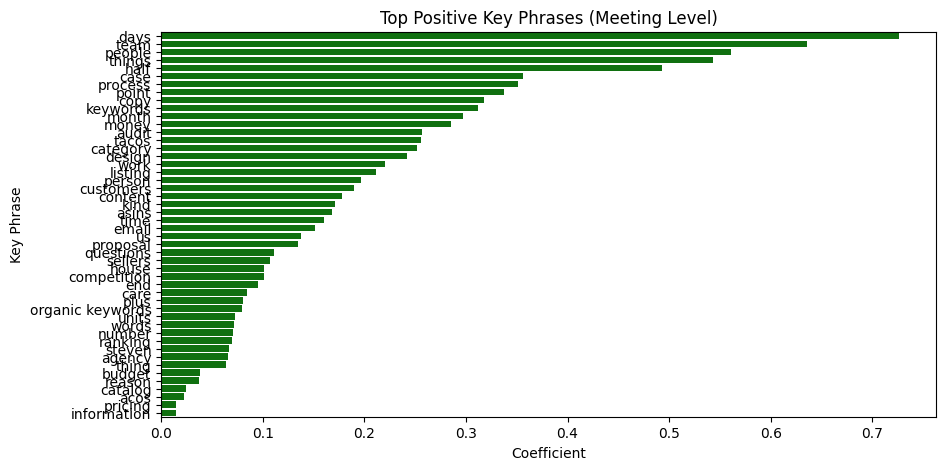

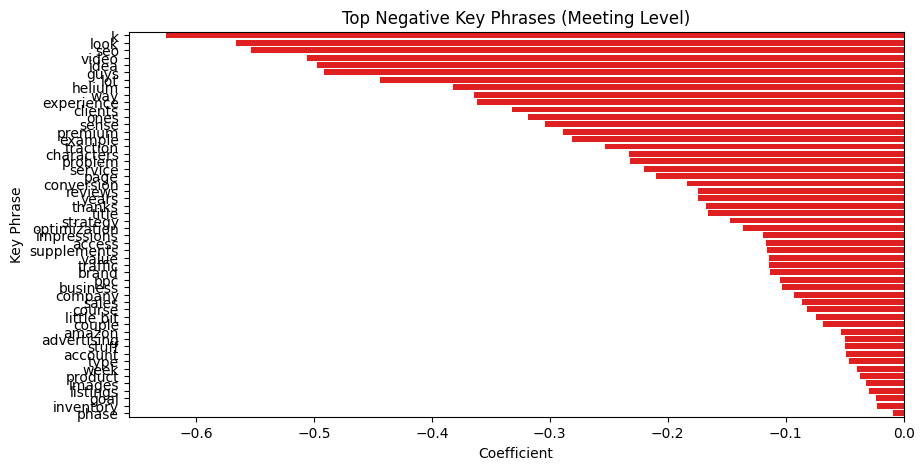

In [18]:
# Separate positive and negative coefficients
top_positive_meeting = coefficients_meeting[coefficients_meeting['coefficient'] > 0].head(100)
top_negative_meeting = coefficients_meeting[coefficients_meeting['coefficient'] < 0].head(100)

# Plotting top positive phrases
plt.figure(figsize=(10,5))
sns.barplot(x='coefficient', y='phrase', data=top_positive_meeting, color='green')
plt.title('Top Positive Key Phrases (Meeting Level)')
plt.xlabel('Coefficient')
plt.ylabel('Key Phrase')
plt.show()

# Plotting top negative phrases
plt.figure(figsize=(10,5))
sns.barplot(x='coefficient', y='phrase', data=top_negative_meeting, color='red')
plt.title('Top Negative Key Phrases (Meeting Level)')
plt.xlabel('Coefficient')
plt.ylabel('Key Phrase')
plt.show()

### **Phrase-Level Visualization**

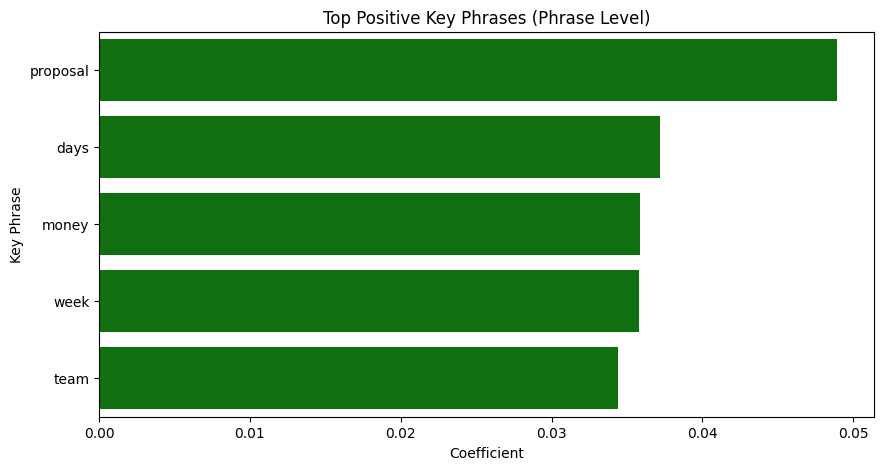

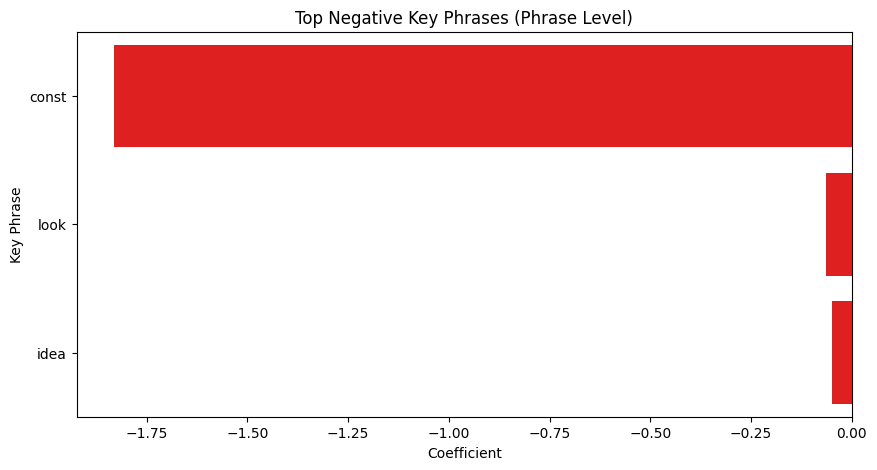

In [19]:
# For Poisson regression results
# Extract top positive and negative coefficients
significant_phrases_phrase['abs_coef'] = significant_phrases_phrase['Coef.'].abs()
significant_phrases_phrase.sort_values('abs_coef', ascending=False, inplace=True)

top_positive_phrase = significant_phrases_phrase[significant_phrases_phrase['Coef.'] > 0].head(100)
top_negative_phrase = significant_phrases_phrase[significant_phrases_phrase['Coef.'] < 0].head(100)

# Plotting top positive phrases
plt.figure(figsize=(10,5))
sns.barplot(x='Coef.', y='phrase', data=top_positive_phrase, color='green')
plt.title('Top Positive Key Phrases (Phrase Level)')
plt.xlabel('Coefficient')
plt.ylabel('Key Phrase')
plt.show()

# Plotting top negative phrases
plt.figure(figsize=(10,5))
sns.barplot(x='Coef.', y='phrase', data=top_negative_phrase, color='red')
plt.title('Top Negative Key Phrases (Phrase Level)')
plt.xlabel('Coefficient')
plt.ylabel('Key Phrase')
plt.show()

<a id='conclusion'></a>
## **11. Conclusion**

TBA Subtask 8